In [265]:
import pandas as pd
import numpy as np

import psycopg2

from datetime import datetime
import time

from database_config import postgres as cfg, cust_list

import matplotlib.pyplot as plt
import seaborn as sns

#import autocorr and PAutocorr
from statsmodels.tsa.arima_model import ARMA

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [266]:
conn = psycopg2.connect(database=cfg['database'],user=cfg['user'],password=cfg['password'],host=cfg['host'],port="5432")

In [267]:
#this works with the last days of the month as well. 
todays_date = str(datetime.today())[:10]

In [268]:
important_customers = cust_list

In [269]:
query = (  
'''SELECT 
    ct.customer_id, 
    ct.resolution, 
    ct.started_at,
    cpf."name" AS attribute_name, 
    cpf."Total_NAs", 
    cpf.curation_tasks_count
FROM "curation_tasks" AS ct

INNER JOIN 
    (SELECT 
        cpf.customer_id,
        cpf.curation_task_id,
        cpf.name,
        SUM(CASE WHEN cpf.value = 'n/a' THEN 1 ELSE 0 END) as "Total_NAs",
        COUNT(cpf.id) AS curation_tasks_count
    FROM "public"."curated_product_fields"  as cpf
    WHERE customer_id = {}
    GROUP BY    
        cpf.customer_id,
        cpf.curation_task_id,
        cpf.name
    ) AS cpf
ON ct.id = cpf.curation_task_id

WHERE started_at >= CURRENT_TIMESTAMP - INTERVAL '14 days'
--- specific resolution that are not taken care of my rules or bulk
AND (ct.resolution IS NULL OR ct.resolution = 'misclassified') 
AND ct.customer_id = {}
ORDER BY started_at;
''')

In [270]:
master_data = pd.DataFrame()
for cust in important_customers:
    #Returning the data in pandas to export it as a CSV.
    data = pd.read_sql(query.format(cust,cust),conn)
    if data.shape[0] != 0:
        data['customer_name']= important_customers[cust]
    else:
        print('No data available in your time frame for Cust_id ',cust)
        pass
    master_data = master_data.append(data,sort=False)
    print(cust, 'Data Grab Complete')
    time.sleep(10)

55 Data Grab Complete
75 Data Grab Complete
No data available in your time frame for Cust_id  77
77 Data Grab Complete
No data available in your time frame for Cust_id  78
78 Data Grab Complete
71 Data Grab Complete


In [271]:
master_data.to_csv('./data/master_data.csv')

# Reading in Prior data

In [272]:
master_data = pd.read_csv('./data/master_data.csv')

In [273]:
df = master_data

In [274]:
df['started_at'] = pd.to_datetime(df['started_at'])

In [275]:
df.drop(columns='Unnamed: 0',inplace=True)

In [276]:
df['date']= [d.date() for d in  df['started_at']]
df['time']= [d.time() for d in  df['started_at']]

In [277]:
df['hour'] = [d.hour for d in df['time']]

# Manuel Method to study Trends

In [278]:
gpby = df[['attribute_name',
       'Total_NAs', 'curation_tasks_count', 'customer_name', 'date', 'time',
       'hour']].groupby(by=['date','hour','attribute_name']).sum().groupby(level=[2]).cumsum()

In [279]:
gpby['% of tasks'] = round(gpby['Total_NAs']/gpby['curation_tasks_count']*100,2)

In [280]:
crn = gpby[(gpby['% of tasks']>60) & (gpby['Total_NAs']>100)]

In [281]:
crn.sort_values(by='% of tasks',ascending=False,inplace=True)

C:\Users\groupby\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [282]:
foo = crn.reset_index(level=[0,1],drop=True)

In [283]:
hi_na_names =foo.index.unique()

In [284]:
df['Total_NAs'] = df['Total_NAs'].astype('int64')

In [285]:
stgpby = df[df['attribute_name'].isin(hi_na_names)].groupby(by=['attribute_name','customer_name']).sum().sort_values('Total_NAs',ascending=False)

In [286]:
stgpby.shape

(19, 5)

In [287]:
stgpby.drop(columns='hour')

,,customer_id,resolution,Total_NAs,curation_tasks_count
attribute_name,customer_name,,,,
clothing_features,Dicks Sporting Goods,91050,0.0,6615,7224
features,Burlington,231247,0.0,3078,4721
padding,Dicks Sporting Goods,24225,0.0,3069,3104
concern,CVS,148885,0.0,2233,3421
search_accessory,Dicks Sporting Goods,99525,0.0,1327,1327
soccer_goalie_glove_type,Dicks Sporting Goods,18225,0.0,843,1413
width,Burlington,37488,0.0,590,613
protection,Dicks Sporting Goods,10350,0.0,588,635
cup_supporter_type,Dicks Sporting Goods,10200,0.0,501,684


In [289]:
df.sort_values(['started_at','attribute_name'],inplace=True)

In [290]:
df.sort_values(['started_at'],ascending=False,inplace=True)

In [291]:
hi_na_names

Index(['protection', 'cup_supporter_features', 'padding', 'search_accessory',
       'width', 'clothing_features', 'spf', 'hair_type', 'key_ingredient',
       'soccer_goalie_glove_type', 'heel_shape', 'symptom',
       'cup_supporter_type', 'skin_type', 'occasions', 'shoe_features',
       'features', 'concern'],
      dtype='object', name='attribute_name')

In [292]:
pt = pd.pivot_table(df,values='Total_NAs',index=['started_at'],columns=['attribute_name'],fill_value=0,aggfunc=np.sum)

In [293]:
high_col = []
for col in pt.columns:
    if pt[col].sum() > 0:
        high_col.append(col)

In [294]:
high_na = pt[high_col]

In [295]:
na_totals = high_na.sum().sort_values(ascending=False)

In [296]:
na_totals.head(20)

attribute_name
fabric_technology           13764
fabric                       8651
clothing_features            6615
closure                      4995
features                     3080
padding                      3069
concern                      2233
neckline                     1441
search_accessory             1327
shoe_width                   1033
soccer_goalie_glove_type      843
specialty_padding_type        682
width                         590
protection                    588
cup_supporter_type            501
shoe_features                 439
form                          429
primary_flavor                402
cup_supporter_features        390
heel_shape                    374
dtype: int64

In [297]:
pt.dropna(inplace=True)

# Testing an ARIMA model anomaly detection

Reasoning: This could be something we want because with anomoaly detection, we can trigger when we are getting too many NA values. Once we have this, we can pause the system.
In combination with linear regression, we can use the coeffients to learn which weights are causing the most N/A values to investigate. 

The current detection is on 

In [298]:
ar1 = ARMA(pt.sum(),(1,0)).fit()

C:\Users\groupby\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\groupby\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\groupby\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\groupby\Anaconda3\l

In [299]:
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  116
Model:                     ARMA(1, 0)   Log Likelihood               -1011.161
Method:                       css-mle   S.D. of innovations           1475.466
Date:                Tue, 30 Oct 2018   AIC                           2028.322
Time:                        13:17:49   BIC                           2036.583
Sample:                             0   HQIC                          2031.675
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        483.4383    271.389      1.781      0.078     -48.474    1015.351
ar.L1.y        0.4995      0.080      6.269      0.000       0.343       0.656
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0020           +0.0000j            2.0020            0.0000
-----------------------------------------------------------------------------
"""

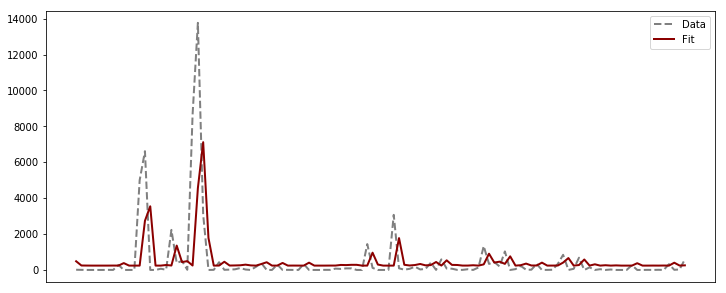

In [300]:
# input time values (into the AR model) are from observed data
predictions = ar1.predict()

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(pt.sum(), lw=2, color='grey', ls='dashed',label='Data')
ax.plot(predictions, lw=2, color='darkred',label='Fit')
plt.xticks(())
plt.legend()
plt.show()

# Regressor to identify items that cause the most N/A values

In [301]:
df.head()

,customer_id,resolution,started_at,attribute_name,Total_NAs,curation_tasks_count,customer_name,date,time,hour
127921,75,NaN,2018-10-30 10:38:35.143056,shorts_type,0,1,Dicks Sporting Goods,2018-10-30,10:38:35.143056,10
19058,55,NaN,2018-10-30 10:36:44.183244,lifestage,0,1,CVS,2018-10-30,10:36:44.183244,10
127920,75,NaN,2018-10-30 10:36:36.092626,shorts_type,0,1,Dicks Sporting Goods,2018-10-30,10:36:36.092626,10
127919,75,NaN,2018-10-30 10:36:29.681074,shorts_type,0,1,Dicks Sporting Goods,2018-10-30,10:36:29.681074,10
127918,75,NaN,2018-10-30 10:36:26.540878,shorts_type,0,1,Dicks Sporting Goods,2018-10-30,10:36:26.540878,10


In [302]:
gb = df[['customer_name','attribute_name','Total_NAs']].groupby(by=['customer_name','attribute_name']).sum()

In [303]:
le = LabelEncoder()

In [304]:
le_index = le.fit_transform(gb.index.values)

In [305]:
gb.index = le_index

In [306]:
gb.reset_index(inplace=True)
gb.rename(columns={'index':'attribute_names'}, inplace=True)

In [307]:
X = gb['attribute_names']
y = gb['Total_NAs']

In [308]:
X_dum = pd.get_dummies(X,drop_first=True)

In [309]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.33, random_state=42)

In [310]:
model = LinearRegression()

In [311]:
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [312]:
model.score(X_test,y_test)

-0.0005075087410695289

In [313]:
y_pred = model.predict(X_test)

In [314]:
rank_dict = dict(zip(le.inverse_transform(X_train.columns),model.coef_))

C:\Users\groupby\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:166: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [315]:
mean_absolute_error(y_test,y_pred)

746.946805666934

In [316]:
rank = pd.DataFrame.from_dict(rank_dict,orient='index',columns=['mean_abs_error'])

In [317]:
priority_list = rank[rank['mean_abs_error']>0].sort_values(by='mean_abs_error',ascending=False)

In [318]:
priority_list.head(5)

,mean_abs_error
"(Dicks Sporting Goods, fabric)",8115.436782
"(Dicks Sporting Goods, clothing_features)",6196.436782
"(Dicks Sporting Goods, closure)",4452.436782
"(Dicks Sporting Goods, padding)",2650.436782
"(CVS, concern)",1814.436782
